# K means clustering with Elbow method

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
import scipy.stats as stats

### The data set is available in the 'Data' folder.  File name:llama_movements.7z.001

In [3]:
df1=pd.read_csv('llama_movements.csv')
#df2=pd.read_csv('historical_weather.csv')

# Data preprocessing

In [20]:
df1.head()

TRIP ID        START TIME         STOP TIME  LLAMA ID  \
0  20941785   9/27/2018 17:36   9/27/2018 18:02      1420   
1  21032144   10/3/2018 17:35   10/3/2018 18:01      4539   
2  21203053  10/16/2018 17:25  10/16/2018 17:52      4261   
3  19973129    8/5/2018 19:01    8/5/2018 19:38      5865   
4  18241036   4/30/2018 23:06   4/30/2018 23:34      6047   

   TRIP DURATION (SECONDS)  FROM HABITAT NAME TO HABITAT NAME  \
0                     1536  Gradients Descent       Peachtree   
1                     1555  Gradients Descent       Peachtree   
2                     1642  Gradients Descent       Peachtree   
3                     2220      Random Forest       Peachtree   
4                     1721      Random Forest       Peachtree   

   FROM HABITAT ID  FROM LATITUDE  FROM LONGITUDE  TO HABITAT ID  TO LATITUDE  \
0               23      -9.205515      -74.973485              0    -9.217429   
1               23      -9.205515      -74.973485              0    -9.217429   
2               23      -9.205515      -74.973485              0    -9.217429   
3                3      -9.190730      -74.955617              0    -9.217429   
4                3      -9.190730      -74.955617              0    -9.217429   

   TO LONGITUDE  start hour  stop hour  START DAY   STOP DAY  
0    -74.996096          17         18 2018-09-27 2018-09-27  
1    -74.996096          17         18 2018-10-03 2018-10-03  
2    -74.996096          17         17 2018-10-16 2018-10-16  
3    -74.996096          19         19 2018-08-05 2018-08-05  
4    -74.996096          23         23 2018-04-30 2018-04-30

In [21]:
# splitting the datetime into date and time variable
df1['start hour']=(df1['START TIME'].str.split(" ", expand=True)[1].str.split(":", expand=True)[0]).astype("int")
df1['stop hour']=(df1['STOP TIME'].str.split(" ", expand=True)[1].str.split(":", expand=True)[0]).astype("int")
df1['START DAY']=pd.to_datetime(df1['START TIME'].str.split(" ", expand=True)[0])
df1['STOP DAY']=pd.to_datetime(df1['STOP TIME'].str.split(" ", expand=True)[0])
df1.head()

TRIP ID        START TIME         STOP TIME  LLAMA ID  \
0  20941785   9/27/2018 17:36   9/27/2018 18:02      1420   
1  21032144   10/3/2018 17:35   10/3/2018 18:01      4539   
2  21203053  10/16/2018 17:25  10/16/2018 17:52      4261   
3  19973129    8/5/2018 19:01    8/5/2018 19:38      5865   
4  18241036   4/30/2018 23:06   4/30/2018 23:34      6047   

   TRIP DURATION (SECONDS)  FROM HABITAT NAME TO HABITAT NAME  \
0                     1536  Gradients Descent       Peachtree   
1                     1555  Gradients Descent       Peachtree   
2                     1642  Gradients Descent       Peachtree   
3                     2220      Random Forest       Peachtree   
4                     1721      Random Forest       Peachtree   

   FROM HABITAT ID  FROM LATITUDE  FROM LONGITUDE  TO HABITAT ID  TO LATITUDE  \
0               23      -9.205515      -74.973485              0    -9.217429   
1               23      -9.205515      -74.973485              0    -9.217429   
2               23      -9.205515      -74.973485              0    -9.217429   
3                3      -9.190730      -74.955617              0    -9.217429   
4                3      -9.190730      -74.955617              0    -9.217429   

   TO LONGITUDE  start hour  stop hour  START DAY   STOP DAY  
0    -74.996096          17         18 2018-09-27 2018-09-27  
1    -74.996096          17         18 2018-10-03 2018-10-03  
2    -74.996096          17         17 2018-10-16 2018-10-16  
3    -74.996096          19         19 2018-08-05 2018-08-05  
4    -74.996096          23         23 2018-04-30 2018-04-30

# Clustering the habitats depending on the number of llamas' arriving and departing every hour to find out a geographic pattern in movements

In [25]:
# In this problem also, we are considering the trips which started and ended in the same day.

c=df1[(df1['START DAY']==df1['STOP DAY'])].groupby(['START DAY','start hour','stop hour','FROM HABITAT ID','TO HABITAT ID'])['LLAMA ID'].nunique().reset_index().sort_values(by='LLAMA ID',ascending=False).rename(columns={'LLAMA ID':'LLAMA COUNT','START DAY':'Day'})

c.head()

Day  start hour  stop hour  FROM HABITAT ID  TO HABITAT ID  \
107572 2018-07-18           8          8               23              3   
138348 2018-09-24          17         17                3             23   
117176 2018-08-06          17         17                3             23   
140864 2018-10-01          17         17                3             23   
94759  2018-06-19          17         17                3             23   

        LLAMA COUNT  
107572           22  
138348           22  
117176           22  
140864           21  
94759            21

In [26]:
temp1=c.groupby(['Day','start hour','FROM HABITAT ID'])['LLAMA COUNT'].sum().reset_index().rename(columns={'start hour':'hour','FROM HABITAT ID':'ID','LLAMA COUNT':'LLAMA DEPARTED'})
temp2=c.groupby(['Day','stop hour','TO HABITAT ID'])['LLAMA COUNT'].sum().reset_index().rename(columns={'stop hour':'hour','TO HABITAT ID':'ID','LLAMA COUNT':'LLAMA ARRIVED'})


In [27]:
df_cl=pd.merge(temp1,temp2,how='left',on=['Day','hour','ID']).fillna(0)
df_cl['LLAMA ARRIVED']=df_cl['LLAMA ARRIVED'].astype('int64')
df_cl=df_cl[['Day','hour','LLAMA DEPARTED','LLAMA ARRIVED','ID']]
df_cl.head()

Day  hour  LLAMA DEPARTED  LLAMA ARRIVED  ID
0 2017-07-01     0               2              0   3
1 2017-07-01     0               1              1  23
2 2017-07-01     1               1              0   0
3 2017-07-01     1               1              1   3
4 2017-07-01     1               1              0  14

In [28]:
x=df_cl.iloc[ :,[2,3]]
#y=df_cl.iloc[ :, -1].values

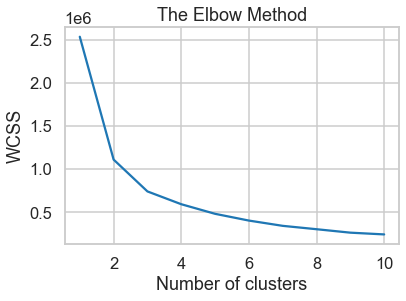

In [29]:
# We are using Elbow method to find out the optimal number of clusters needed 

from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state= 42)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Using k=5 because there is no improvement in WCSS after 5. We can use 4 also and see the result. For this illustration, I am using 5

In [30]:
kmeans=KMeans(n_clusters=5, init='k-means++', random_state= 42)
y=kmeans.fit_predict(x)


In [31]:
df_predict=pd.DataFrame(y,columns=['Cluster'])
df_final=pd.concat([df_cl,df_predict],axis=1)
df_final.head()

Day  hour  LLAMA DEPARTED  LLAMA ARRIVED  ID  Cluster
0 2017-07-01     0               2              0   3        3
1 2017-07-01     0               1              1  23        3
2 2017-07-01     1               1              0   0        3
3 2017-07-01     1               1              1   3        3
4 2017-07-01     1               1              0  14        3

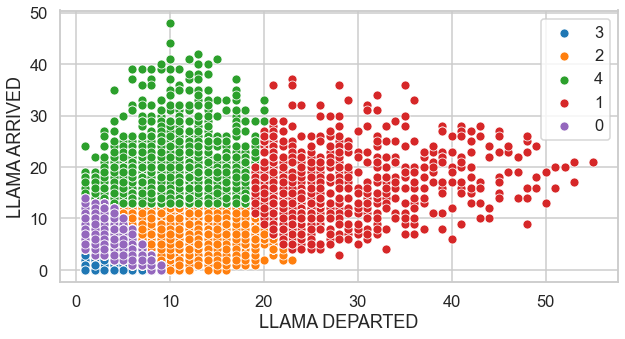

In [32]:
# Here a visual representation is made to see the habitats based on the movements of Llamas.
# We refer to the Dashboard for dynamic visualization which will show the geographic movments during different period of time.

sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(10,5))
sns.scatterplot(df_final['LLAMA DEPARTED'][df_final['Cluster']==3],df_final['LLAMA ARRIVED'][df_final['Cluster']==3],label=3)
sns.scatterplot(df_final['LLAMA DEPARTED'][df_final['Cluster']==2],df_final['LLAMA ARRIVED'][df_final['Cluster']==2],label=2)
sns.scatterplot(df_final['LLAMA DEPARTED'][df_final['Cluster']==4],df_final['LLAMA ARRIVED'][df_final['Cluster']==4],label=4)
sns.scatterplot(df_final['LLAMA DEPARTED'][df_final['Cluster']==1],df_final['LLAMA ARRIVED'][df_final['Cluster']==1],label=1)
sns.scatterplot(df_final['LLAMA DEPARTED'][df_final['Cluster']==0],df_final['LLAMA ARRIVED'][df_final['Cluster']==0],label=0)

In [54]:
#b.to_csv('llama_group.csv',index=False)
#df_final.to_csv('llama_cluster.csv',index=False)